## **Import Important Libraries**

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from itertools import cycle

## **Read Data**

In [76]:
data_df = pd.read_csv('online_gaming_behavior_dataset.csv')
data_df.head()

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium


## **EDA**

In [77]:
data_df.shape

(40034, 13)

In [78]:
data_df.isnull().sum()

PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64

In [79]:
data_df.describe()

,PlayerID,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,29016.500000,31.992531,12.024365,0.200854,9.471774,94.792252,49.655568,24.526477
std,11556.964675,10.043227,6.914638,0.400644,5.763667,49.011375,28.588379,14.430726
min,9000.000000,15.000000,0.000115,0.000000,0.000000,10.000000,1.000000,0.000000
25%,19008.250000,23.000000,6.067501,0.000000,4.000000,52.000000,25.000000,12.000000
50%,29016.500000,32.000000,12.008002,0.000000,9.000000,95.000000,49.000000,25.000000
75%,39024.750000,41.000000,17.963831,0.000000,14.000000,137.000000,74.000000,37.000000
max,49033.000000,49.000000,23.999592,1.000000,19.000000,179.000000,99.000000,49.000000


In [80]:
data_df.describe(include='O')

,Gender,Location,GameGenre,GameDifficulty,EngagementLevel
count,40034,40034,40034,40034,40034
unique,2,4,5,3,3
top,Male,USA,Sports,Easy,Medium
freq,23959,16000,8048,20015,19374


In [81]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

In [82]:
data_df['EngagementLevel'].value_counts()

EngagementLevel
Medium    19374
High      10336
Low       10324
Name: count, dtype: int64

In [83]:
target_column = 'EngagementLevel'
X = data_df.drop(columns=[target_column])
y = data_df[target_column]

In [84]:
categorical_columns = ['Gender', 'Location', 'GameGenre', 'GameDifficulty']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

X = pd.get_dummies(X, drop_first=True)

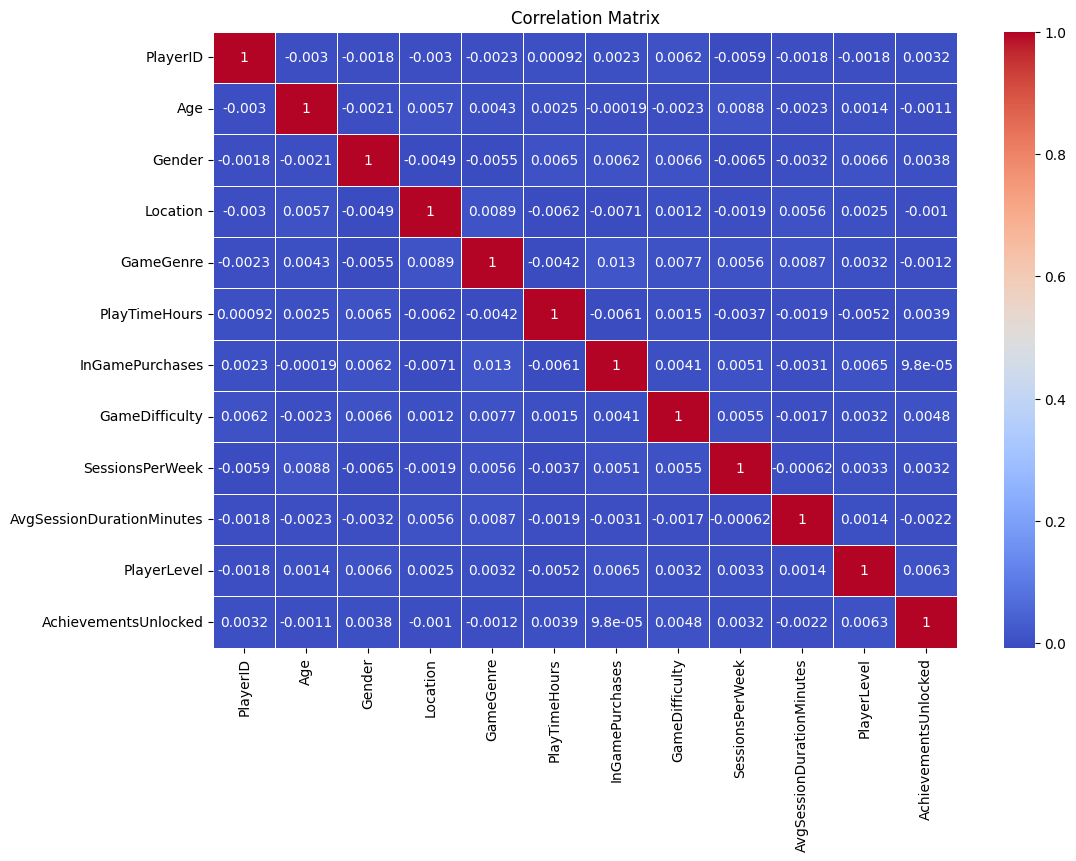

In [85]:
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## **Split Data**

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## **Scale Data**

In [87]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## **create function that print roc curve for each label**

In [ ]:
def labels_roc(classifier, features, labels):
    if len(set(labels)) > 1:
        y_test_binarized = label_binarize(labels, classes=classifier.classes_)
        n_classes = y_test_binarized.shape[1]

        y_score = classifier.predict_proba(features)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
    
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC AUC score is not defined as only one class is present in y_true.")

## **Train and Test Gaussian Naive Bayes**

In [89]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_sc, y_train)

y_pred_nb = nb_model.predict(X_test_sc)
y_pred_prob_nb = nb_model.predict_proba(X_test_sc)

In [90]:
class_order = nb_model.classes_
print("Class order:", class_order)

results_df = pd.DataFrame({
    'Actual Label' : y_test,
    'Predicted Label' : y_pred_nb
})

for i, class_name in enumerate(class_order):
    results_df[f'Predicted Probability {class_name}'] = np.round(y_pred_prob_nb[:, i], 2)

results_df.head()

Class order: ['High' 'Low' 'Medium']


,Actual Label,Predicted Label,Predicted Probability High,Predicted Probability Low,Predicted Probability Medium
34667,Medium,Medium,0.22,0.07,0.71
22227,Medium,Medium,0.19,0.17,0.64
24899,Medium,Medium,0.01,0.34,0.65
35415,Medium,Medium,0.22,0.16,0.62
21440,Medium,Medium,0.34,0.13,0.53


In [91]:
print('\nNaive Bayes Classifier:')
training_accuarcy = accuracy_score(y_train, nb_model.predict(X_train_sc))
testing_accuracy = accuracy_score(y_test, y_pred_nb)

print(f'Training Accuracy: {training_accuarcy}')
print(f'Testing Accuracy: {testing_accuracy}')


Naive Bayes Classifier:
Training Accuracy: 0.8447960033305578
Testing Accuracy: 0.8434494817035094


In [92]:
conf_matrix = confusion_matrix(y_test, y_pred_nb, labels=class_order)
print("Confusion Matrix:")
print(conf_matrix)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_order, columns=class_order)
print("Confusion Matrix With Class Labels:")
print(conf_matrix_df)

Confusion Matrix:
[[3234  109  814]
 [  96 2854 1133]
 [ 129  226 7419]]
Confusion Matrix With Class Labels:
        High   Low  Medium
High    3234   109     814
Low       96  2854    1133
Medium   129   226    7419


In [93]:
class_report = classification_report(y_test, y_pred_nb)
print("Naïve Bayes Classification Report:")
print(class_report)

Naïve Bayes Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.78      0.85      4157
         Low       0.89      0.70      0.78      4083
      Medium       0.79      0.95      0.87      7774

    accuracy                           0.84     16014
   macro avg       0.87      0.81      0.83     16014
weighted avg       0.86      0.84      0.84     16014



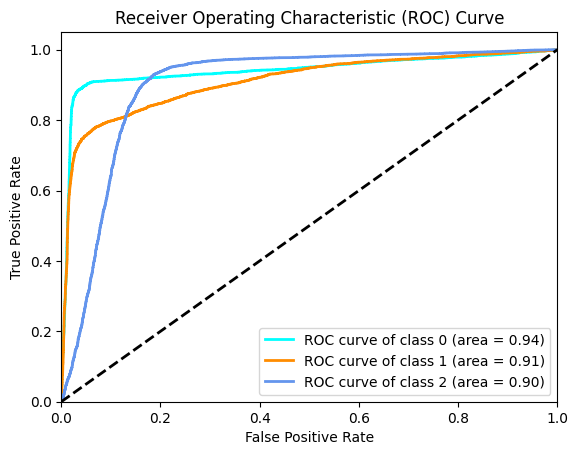

In [94]:
labels_roc(nb_model, X_test_sc, y_test)

## **Train and Test KNN Model**

In [95]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_sc, y_train)

y_pred_knn = knn_model.predict(X_test_sc)
y_pred_prob_knn = knn_model.predict_proba(X_test_sc)

In [96]:
class_order = knn_model.classes_
print("Class order:", class_order)

results_df = pd.DataFrame({
    'Actual Label' : y_test,
    'Predicted Label' : y_pred_knn
})

for i, class_name in enumerate(class_order):
    results_df[f'Predicted Probability {class_name}'] = np.round(y_pred_prob_knn[:, i], 2)

results_df.head()

Class order: ['High' 'Low' 'Medium']


,Actual Label,Predicted Label,Predicted Probability High,Predicted Probability Low,Predicted Probability Medium
34667,Medium,Medium,0.00,0.00,1.00
22227,Medium,High,0.67,0.00,0.33
24899,Medium,Low,0.00,0.67,0.33
35415,Medium,Medium,0.33,0.00,0.67
21440,Medium,Medium,0.33,0.00,0.67


In [97]:
print("\nK-Nearst Neighbors Classification")
training_accuracy = accuracy_score(y_train, knn_model.predict(X_train_sc))
testing_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"Training Accuracy: {training_accuarcy}")
print(f"Testing Accuracy: {testing_accuracy}")


K-Nearst Neighbors Classification
Training Accuracy: 0.8447960033305578
Testing Accuracy: 0.7141875858623704


In [98]:
conf_matrix = confusion_matrix(y_test, y_pred_knn, labels=class_order)
print('Confusion Matrix:')
print(conf_matrix)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_order, columns=class_order)
print('Confusion Matrix With Class Labels:')
print(conf_matrix_df)

Confusion Matrix:
[[3049  132  976]
 [ 255 2360 1468]
 [ 975  771 6028]]
Confusion Matrix With Class Labels:
        High   Low  Medium
High    3049   132     976
Low      255  2360    1468
Medium   975   771    6028


In [99]:
class_report = classification_report(y_test, y_pred_knn)
print('K-Nearst Neighbors Classification Report:')
print(class_report)

K-Nearst Neighbors Classification Report:
              precision    recall  f1-score   support

        High       0.71      0.73      0.72      4157
         Low       0.72      0.58      0.64      4083
      Medium       0.71      0.78      0.74      7774

    accuracy                           0.71     16014
   macro avg       0.72      0.70      0.70     16014
weighted avg       0.71      0.71      0.71     16014



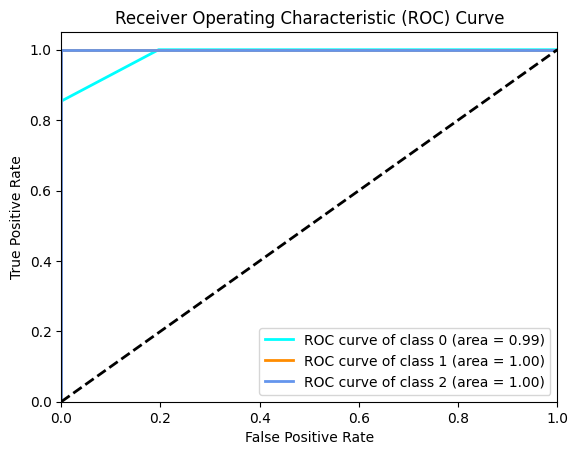

In [100]:
labels_roc(knn_model, X_test_sc, y_pred_knn)

## **Train and Test Decision Tree Classifier**

In [101]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_sc, y_train)

y_pred_dt = dt_model.predict(X_test_sc)
y_pred_prob_dt = dt_model.predict_proba(X_test_sc)

In [102]:
class_order = dt_model.classes_
print("Class Order:", class_order)

results_df = pd.DataFrame({
    'Actual Label' : y_test,
    'Predicted Label' : y_pred_dt
})

for i, class_name in enumerate(class_order):
    results_df[f'Predicted Probability {class_name}'] = np.round(y_pred_prob_dt[:, i], 2)

results_df.head()

Class Order: ['High' 'Low' 'Medium']


,Actual Label,Predicted Label,Predicted Probability High,Predicted Probability Low,Predicted Probability Medium
34667,Medium,Medium,0.0,0.0,1.0
22227,Medium,Medium,0.0,0.0,1.0
24899,Medium,High,1.0,0.0,0.0
35415,Medium,Medium,0.0,0.0,1.0
21440,Medium,Medium,0.0,0.0,1.0


In [103]:
print("\nDecision Tree Classifier:")
training_accuracy = accuracy_score(y_train, dt_model.predict(X_train_sc))
testing_accuracy = accuracy_score(y_test, y_pred_dt)

print(f'Training Accuracy: {training_accuracy}')
print(f'Testing Accuracy: {testing_accuracy}')


Decision Tree Classifier:
Training Accuracy: 1.0
Testing Accuracy: 0.8285250405894842


In [104]:
scores = cross_val_score(dt_model, X_train_sc, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.83180683 0.82618651 0.83409659 0.82847627 0.82285595]
Mean cross-validation score: 0.828684429641965


In [105]:
conf_matrix = confusion_matrix(y_test, y_pred_dt, labels=class_order)
print('Confusion Matrix:')
print(conf_matrix)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_order, columns=class_order)
print("Confusion Matrix With Class Labels:")
print(conf_matrix_df)

Confusion Matrix:
[[3362  285  510]
 [ 290 3275  518]
 [ 559  584 6631]]
Confusion Matrix With Class Labels:
        High   Low  Medium
High    3362   285     510
Low      290  3275     518
Medium   559   584    6631


In [106]:
class_report = classification_report(y_test, y_pred_dt)
print("Decision Trees Classification Report:")
print(class_report)

Decision Trees Classification Report:
              precision    recall  f1-score   support

        High       0.80      0.81      0.80      4157
         Low       0.79      0.80      0.80      4083
      Medium       0.87      0.85      0.86      7774

    accuracy                           0.83     16014
   macro avg       0.82      0.82      0.82     16014
weighted avg       0.83      0.83      0.83     16014



## **Train and Test Random Forest Model**

In [107]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_sc, y_train)

y_pred_rf = rf_model.predict(X_test_sc)
y_pred_prob_rf = rf_model.predict_proba(X_test_sc)

In [108]:
class_order = rf_model.classes_
print("Class order:", class_order)

results_df = pd.DataFrame({
    'Actual Label' : y_test,
    'Predicted Label' : y_pred_rf
})


for i, class_name in enumerate(class_order):
    results_df[f'Predicted Probability {class_name}'] = np.round(y_pred_prob_rf[:, i], 2)

results_df.head()

Class order: ['High' 'Low' 'Medium']


,Actual Label,Predicted Label,Predicted Probability High,Predicted Probability Low,Predicted Probability Medium
34667,Medium,Medium,0.08,0.05,0.87
22227,Medium,Medium,0.08,0.04,0.88
24899,Medium,Low,0.06,0.79,0.15
35415,Medium,Medium,0.13,0.06,0.81
21440,Medium,Medium,0.17,0.07,0.76


In [109]:
print('\nRandom Forest Classifier:')
training_accuracy = accuracy_score(y_train, rf_model.predict(X_train_sc))
testing_accuracy = accuracy_score(y_test, y_pred_rf)

print(f'Training Accuracy: {training_accuarcy}')
print(f'Testing Accuracy: {testing_accuracy}')


Random Forest Classifier:
Training Accuracy: 0.8447960033305578
Testing Accuracy: 0.9098288997127514


In [110]:
conf_matrix = confusion_matrix(y_test, y_pred_rf, labels=class_order)
print("Confusion Matrix:")
print(conf_matrix)

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_order, columns=class_order)
print("Confusion Matrix With Class Labels:")
print(conf_matrix_df)

Confusion Matrix:
[[3612  131  414]
 [ 114 3584  385]
 [ 176  224 7374]]
Confusion Matrix With Class Labels:
        High   Low  Medium
High    3612   131     414
Low      114  3584     385
Medium   176   224    7374


In [111]:
class_report = classification_report(y_test, y_pred_rf)
print("Random Forest Classification Report:")
print(class_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.87      0.90      4157
         Low       0.91      0.88      0.89      4083
      Medium       0.90      0.95      0.92      7774

    accuracy                           0.91     16014
   macro avg       0.91      0.90      0.90     16014
weighted avg       0.91      0.91      0.91     16014

